### Import Libraries

In [14]:
from os import listdir
from os.path import isfile, join
import os
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt

### Get number of classes (directories) in the training directory

In [3]:
def get_path_list(root_path):
    
    # Append all directories in the train directory into a list
    training_dirs = [f for f in listdir(root_path)]
    return training_dirs

### Read images and labels from each class in the training directory

In [4]:
def get_class_id(root_path, train_names):
    train_image_list = []
    image_classes_list = []
    
    # Iterate over all directories in the train directory
    for index, name in enumerate(train_names):
        currentDir = join(root_path, name)
        
        # get the list of images in each class
        image_path_list = listdir(currentDir)
        
        # Read and append every images in each class
        for img_path in image_path_list:
            if isfile(join(currentDir, img_path)):
                img = cv2.imread(join(currentDir, img_path))
                
                # Append image
                train_image_list.append(img)
                
                # Append label
                image_classes_list.append(index)
            
    return train_image_list, image_classes_list

### Filter only the face and convert into grayscale for all image in training dataset

In [5]:
def detect_train_faces_and_filter(image_list, image_classes_list):
    
    # Load haarcascade for face detection
    face_cascade = cv2.CascadeClassifier("haarcascade_frontalface_alt.xml")
    
    train_face_grays = []
    filtered_classes_list = []
    
    # Iterate for all images
    for index, img in enumerate(image_list):
        
        # convert image into grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # detect face with scale factor of 1.3 and min neighbors of 5
        faces = face_cascade.detectMultiScale(gray, 1.3, 5)
        
        # If face is identified, iterate over all faces in the image
        if(len(faces) >= 1):
            for (x,y,w,h) in faces:
                
                # Crop only the detected face
                gray_cropped = gray[y:y+h, x:x+w]
                
                # Append the cropped face and its corresponding label
                train_face_grays.append(np.asarray(gray_cropped, dtype=np.uint8))
                filtered_classes_list.append(image_classes_list[index])
    
    return train_face_grays, filtered_classes_list

### Filter only the face and convert into grayscale for all image in testing dataset

In [6]:
def detect_test_faces_and_filter(image_list):
    
    # Load haarcascade for face detection
    face_cascade = cv2.CascadeClassifier("haarcascade_frontalface_alt.xml")
    
    test_face_grays = []
    test_faces_rect = []
    
    # Iterate for all images
    for index, img in enumerate(image_list):
        
        # convert image into grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # detect face with scale factor of 1.1 and min neighbors of 5
        faces = face_cascade.detectMultiScale(gray, 1.1, 5)
        
        # If face is identified, iterate over all faces in the image
        if(len(faces) >= 1):
            for(x,y,w,h) in faces:
                
                # Crop only the detected face
                gray_cropped = gray[y:y+h, x:x+w]
                
                # Append the cropped face and its corresponding label
                test_face_grays.append(np.asarray(gray_cropped, dtype=np.uint8))
                test_faces_rect.append((x,y,w,h))
                
    return test_face_grays, test_faces_rect

### Training the model

In [7]:
def train(train_face_grays, image_classes_list):
    
    # Create a LBPH Face Recognizer model
    model = cv2.face.LBPHFaceRecognizer_create()
    
    # Fitting training dataset into the model
    model.train(np.asarray(train_face_grays), np.asarray(image_classes_list))
    
    # Write the trained model as a file
    model.write('TrainedLBPHFaceRecognizer')
    
    return model

### Reading the test dataset

In [8]:
def get_test_images_data(test_root_path):
    
    test_images_list = []
    
    # Get list of images name in the test directory given from the question
    test_images = listdir(test_root_path)
    
    # Iterate over all images
    for image in test_images:
        
        if isfile(join(test_root_path, image)):
            
            # Read each image
            img = cv2.imread(join(test_root_path, image))
            
            # Append the image to a list
            test_images_list.append(np.asarray(img, dtype=np.uint8))
            
    return test_images_list

### Using the trained model to predict

In [9]:
def predict(recognizer, test_faces_gray):
    
    results = []
    name = ""
    confs = []
    
    for face in test_faces_gray:
        try:
            
            # Predict the face
            predicted, conf = recognizer.predict(face)
            
            # Transform class that categorical into each corresponding name
            if(predicted == 0):
                name =  "Chaeyoung"
            elif(predicted == 1):
                name = "Dahyun"
            elif(predicted == 2):
                name = "Dave"
            elif(predicted == 3):
                name = "Jeongyeon"
            elif(predicted == 4):
                name = "Jihyo"
            elif(predicted == 5):
                name = "Mina"
            elif(predicted == 6):
                name = "Momo"
            elif(predicted == 7):
                name = "Nayeon"
            elif(predicted == 8):
                name = "Sana"
            elif(predicted == 9):
                name = "Tzuyu"
                
            # Store results
            results.append(name)
            
            # The lower the confidence value is, the more confident the model is
            confs.append(math.floor((100 - conf)*10)/10)
            
        except:
            print('No Faces found')
            pass
        
    return results, confs

### Segment the detected face and write the prediction on the image

In [10]:
def draw_prediction_results(predict_results, test_image_list, test_faces_rects, confs, size):
    results = []
    
    # Iterate over all images in the test dataset
    for index, image in enumerate(test_image_list):
        
        # Get the bounding box
        (x, y, w, h) = test_faces_rects[index]
        
        # Create a copy of the test image
        img = image.copy()
        
        # Draw the bounding box as a rectangle on the copied image
        cv2.rectangle(img, (x, y), (x+w, y+h), (0,255,0), 2)
        
        # Write the prediction results 
        cv2.putText(img, predict_results[index], (30,60), cv2.FONT_HERSHEY_SIMPLEX, 1.3, (0,0,255), 2)
        
        # Resize image
        final = cv2.resize(img, (size,size))
        
        # Store the result image
        results.append(np.asarray(final, dtype=np.uint8))
    
    return results

### Concatenate all results into one single image

In [23]:
def combine_and_show_result(image_list, size):
    
    # Iterate and resize every image that has been annotated before
    for image in image_list:
        cv2.resize(image, (size,size))
    
    # Concatenate horizontally using numpy hstack
    combined = np.hstack((image_list[0], image_list[1]))
    for index in range(2, len(image_list)):
        combined = np.hstack((combined, image_list[index]))
    
    # Write a file of the result image
    cv2.imwrite('Result.jpg', combined)
    
    # Show the result image
    plt.figure(figsize=(20,16))
    combined = cv2.cvtColor(combined, cv2.COLOR_BGR2RGB)
    plt.imshow(combined)

# Main

In [12]:
# Define the train path
train_root_path = './images/train/'


# Get the list of classes in the train directory
train_names = get_path_list(train_root_path)

# Get images and its corresponding class from the train directory
train_image_list, image_classes_list = get_class_id(train_root_path, train_names)

# Crop the image to only the face and convert it into grayscale
train_face_grays, filtered_classes_list = detect_train_faces_and_filter(train_image_list, image_classes_list)

# Train the LBPH Face Recognizer model using the train dataset
model = train(train_face_grays, filtered_classes_list)

cv2.destroyAllWindows()

C:\Users\DAVE\Anaconda3\envs\ComputerVision\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


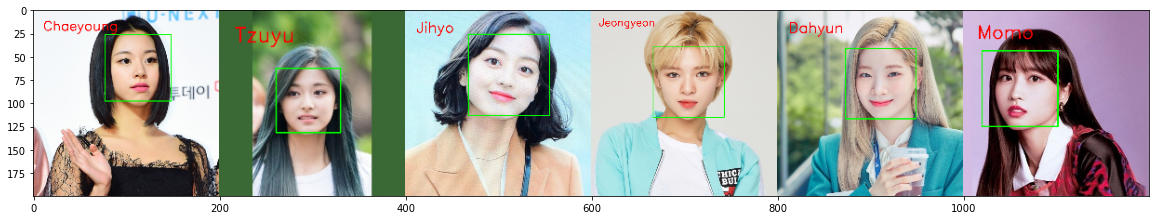

In [24]:
# Create LBPH Face Recognizer Model
lbph = cv2.face.LBPHFaceRecognizer_create()


# Read the model that is writted during training
model = lbph.read('TrainedLBPHFaceRecognizer')

# Define the test path
test_root_path = "./images/test"

# Get the list of images in test directory
test_image_list = get_test_images_data(test_root_path)

# Crop the image to only the face and convert it into grayscale
test_faces_gray, test_faces_rects = detect_test_faces_and_filter(test_image_list)

# Predict results by passing the model and the cropped test dataset
predict_results, confs = predict(lbph, test_faces_gray)

# Draw the bounding box and prediction results
predicted_test_image_list = draw_prediction_results(predict_results, test_image_list, test_faces_rects, confs, 200)

# Concatenate all prediction results into 1 image
combine_and_show_result(predicted_test_image_list, 200)

cv2.destroyAllWindows()